# Analysis Code

In [1]:
import requests
import json

def fetch_news(search_keyword, start_date, end_date, sort_method, save = False):
    api_key = "fcf6368111ce48c3b234b0a479d1dca6"

    url = (
        "https://newsapi.org/v2/everything?"
        f"q={search_keyword}&"
        f"from={start_date}&"
        f"to={end_date}&"
        f"sortBy={sort_method}&"
        f"apiKey={api_key}"
    )

    response = requests.get(url)

    if response.status_code == 200:
        fetch_news_data = response.json()
        if save:
            with open('news_data.json', 'w') as f:
                json.dump(fetch_news_data, f, indent=4)
            print("Data saved to 'news_data.json'")
        return fetch_news_data
    else:
        print(f"Failed to fetch data: {response.status_code} - {response.text}")
        return None

In [2]:
def extract_news_data(title, description, content):
    # Combine title, description, and content
    combined_text = f"{title} {description} {content}".strip()
    return combined_text

In [3]:
from transformers import T5ForConditionalGeneration, T5Tokenizer
import torch
from IPython.display import display, Markdown
import re

# LLM model
cls_model = T5ForConditionalGeneration
cls_tokenizer = T5Tokenizer
device_map="auto"
torch_dtype=torch.float16

tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")

model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large",
                                        torch_dtype=torch_dtype,
                                        device_map=device_map,
                                        trust_remote_code=True,
                                        # cache_dir = "/work/pi_dhruveshpate_umass_edu/aamballa_umass_edu/models/.cache"
                                        )

tokenizer.pad_token =  tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id
model.eval()


/work/pi_mccallum_umass_edu/aamballa_umass_edu/amballaavinash/.conda/envs/Superposed/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The argument `trust_remote_code` is to be used with Auto classe

T5ForConditionalGeneration(
  (shared): Embedding(32128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=1024, out_features=2816, bias=False)
              (wi_1): Linear(in_features=1024, out_features=2816, bias=False)
       

In [31]:
def analyze_news(news_content, ticker):  

    # instruction = "Provide the sentiment of the below {} article as either neutral, positive, or negative. Just return the sentiment as a string. \n {}"

    instruction = """You are a sentiment analysis model. Given a {} article, determine the sentiment of the article as one of the following categories: "Positive", "Negative", or "Neutral". 

                    Article: "{}"
                    
                    Output: Provide only the sentiment label: "Positive", "Negative", or "Neutral" 
                    """


    prompt = instruction.format(ticker, news_content)
    
    # tokenize
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")

    generated_ids = model.generate(input_ids = input_ids, max_new_tokens = 100)

    analyze_news_data = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]    
    # display(Markdown(analyze_news_data))

    return analyze_news_data

def clean_sentiment(content):
    # Remove padding tokens
    sentiment = analyze_news(content, 'apple stock')
    return sentiment.replace("<pad>", "").strip()  


In [32]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, MapType, ArrayType, IntegerType 
from pyspark.sql.functions import col, udf

def sentiment_wrapper(articles):
    """
    Process news articles, apply sentiment analysis, and store results in a JSON file.
    """
    if not articles:
        print("No articles found in the data.")
        return

    # Create a SparkSession
    spark = SparkSession.builder \
        .master('local[*]') \
        .config("spark.driver.memory", "15g") \
        .appName('SentimentAnalysis') \
        .getOrCreate()
    
    # Define schema for DataFrame based on article keys
    schema = StructType([
        StructField("source", MapType(StringType(), StringType()), True),
        StructField("author", StringType(), True),
        StructField("title", StringType(), True),
        StructField("description", StringType(), True),
        StructField("url", StringType(), True),
        StructField("urlToImage", StringType(), True),
        StructField("publishedAt", StringType(), True),
        StructField("content", StringType(), True),
    ])
    
    # Create a DataFrame from articles
    df = spark.createDataFrame(articles, schema)

    # Register `extract_news_data` as UDF to combine article fields into a key
    extract_news_udf = udf(extract_news_data, StringType())
    df = df.withColumn("article_text", extract_news_udf(col("title"), col("description"), col("content")))

    article_text_path = "article_text.json"
    article_text_list = df.select("article_text").rdd.map(lambda row: row["article_text"]).collect()
    with open(article_text_path, "w") as json_file:
        json.dump(article_text_list, json_file, indent=2)

    # Define and register UDF for sentiment analysis on combined text 
    sentiment_analysis_udf = udf(clean_sentiment, StringType())
    df = df.withColumn("sentiment", sentiment_analysis_udf(df["article_text"]))
    
    # Save results to JSON
    output_file_path = "sentiment_data_0.json"
    df_list = df.select("sentiment").rdd.map(lambda row: row["sentiment"]).collect()
    
    with open(output_file_path, "w") as json_file:
        json.dump(df_list, json_file, indent=2)

    # Stop SparkSession
    spark.stop()

    return output_file_path


In [33]:
def main():
    fetch_news_data = fetch_news('apple stock', '2024-11-15', '2024-11-16', 'popularity', save = True)

    if fetch_news_data and "articles" in fetch_news_data:
        articles = fetch_news_data["articles"]
        sentiment_output_path = sentiment_wrapper(articles)
        print(f"Sentiment analysis results saved to {sentiment_output_path}")
    else:
        print("No articles found or failed to fetch news data.")


In [34]:
if __name__ == "__main__":
    main()

Data saved to 'news_data.json'


Sentiment analysis results saved to sentiment_data_0.json


# Memory Usage and Throughput

### Execute the memory usage code for the first time

In [8]:
import psutil
import GPUtil
import time

def monitor_memory_usage(func, *args, **kwargs):
    """
    Monitors memory usage of CPU and GPU during the execution of the given function.

    Args:
        func (function): The main function to execute.
        *args: Positional arguments to pass to the function.
        **kwargs: Keyword arguments to pass to the function.

    Returns:
        tuple: The output of the executed function and the execution time in seconds.
    """
    start_time = time.time()

    result = func(*args, **kwargs)

    # Get total and used memory (RAM)
    memory_info = psutil.virtual_memory()
    memory_used = (memory_info.total - memory_info.available) / (1024 ** 3)  # Convert to GB

    # Print CPU usage in GB (use virtual memory usage for CPU context)
    cpu_memory_used = memory_used

    gpus = GPUtil.getGPUs()
    if gpus:
        gpu_memory_used = gpus[0].memoryUsed / 1024  # Convert MB to GB
    else:
        gpu_memory_used = 0

    print(f"CPU Memory Usage: {cpu_memory_used:.2f} GB")
    print(f"GPU Memory Usage: {gpu_memory_used:.2f} GB")

    end_time = time.time()

    print(f"Response Time: {end_time - start_time:.2f} seconds")

    return result, end_time - start_time  # Return result and execution time


def calculate_throughput(response_time, num_articles):
    """
    Calculates throughput based on the formula: response_time / number_of_articles.

    Args:
        response_time (float): The total time taken for processing in seconds.
        num_articles (int): The number of articles processed.

    Returns:
        float: The throughput (in seconds per article).
    """
    if num_articles == 0:
        return 0 
    return response_time / num_articles


def main():

    fetch_news_data = fetch_news('apple stock', '2024-11-15', '2024-11-16', 'popularity')
    
    if fetch_news_data and "articles" in fetch_news_data:
        articles = fetch_news_data["articles"]
        output, response_time = monitor_memory_usage(sentiment_wrapper, articles)
        # print(f"Sentiment analysis results saved to {output}")
    else:
        print("No articles found or failed to fetch news data.")
    articles = fetch_news_data["articles"]

    throughput = calculate_throughput(response_time, len(articles))
    print(f"Throughput (seconds per article): {throughput:.4f}")


# Run the main function
if __name__ == "__main__":
    main()


CPU Memory Usage: 70.48 GB
GPU Memory Usage: 1.92 GB
Response Time: 56.32 seconds
Throughput (seconds per article): 0.7611


### Execute the memory usage code using cache

In [9]:
import psutil
import GPUtil
import time

def monitor_memory_usage(func, *args, **kwargs):
    """
    Monitors memory usage of CPU and GPU during the execution of the given function.

    Args:
        func (function): The main function to execute.
        *args: Positional arguments to pass to the function.
        **kwargs: Keyword arguments to pass to the function.

    Returns:
        tuple: The output of the executed function and the execution time in seconds.
    """
    start_time = time.time()

    result = func(*args, **kwargs)

    # Get total and used memory (RAM)
    memory_info = psutil.virtual_memory()
    memory_used = (memory_info.total - memory_info.available) / (1024 ** 3)  # Convert to GB

    # Print CPU usage in GB (use virtual memory usage for CPU context)
    cpu_memory_used = memory_used

    gpus = GPUtil.getGPUs()
    if gpus:
        gpu_memory_used = gpus[0].memoryUsed / 1024  # Convert MB to GB
    else:
        gpu_memory_used = 0

    print(f"CPU Memory Usage: {cpu_memory_used:.2f} GB")
    print(f"GPU Memory Usage: {gpu_memory_used:.2f} GB")

    end_time = time.time()

    print(f"Response Time: {end_time - start_time:.2f} seconds")

    return result, end_time - start_time  # Return result and execution time


def calculate_throughput(response_time, num_articles):
    """
    Calculates throughput based on the formula: response_time / number_of_articles.

    Args:
        response_time (float): The total time taken for processing in seconds.
        num_articles (int): The number of articles processed.

    Returns:
        float: The throughput (in seconds per article).
    """
    if num_articles == 0:
        return 0 
    return response_time / num_articles


def main():

    fetch_news_data = fetch_news('apple stock', '2024-11-15', '2024-11-16', 'popularity')
    
    if fetch_news_data and "articles" in fetch_news_data:
        articles = fetch_news_data["articles"]
        output, response_time = monitor_memory_usage(sentiment_wrapper, articles)
        # print(f"Sentiment analysis results saved to {output}")
    else:
        print("No articles found or failed to fetch news data.")
    articles = fetch_news_data["articles"]

    throughput = calculate_throughput(response_time, len(articles))
    print(f"Throughput (seconds per article): {throughput:.4f}")


# Run the main function
if __name__ == "__main__":
    main()


CPU Memory Usage: 70.96 GB
GPU Memory Usage: 1.92 GB
Response Time: 42.94 seconds
Throughput (seconds per article): 0.5803


# Accuracy

In [37]:
import openai
import os
import json

openai.api_key = ""  # use your open ai key 




def get_chatgpt_response(prompt, model="gpt-4o-mini", temperature=0.7, max_tokens=2048):
    completion = openai.ChatCompletion.create(
      model="gpt-4o-mini",
      messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": prompt}
      ],
        temperature=temperature,
        max_tokens=max_tokens,
    )

    return (completion.choices[0].message.content)



def analyze_news_openai(news_content, ticker):
    results = []
    for news in news_content:
        instruction = """You are a sentiment analysis model. Given a {} article, determine the sentiment of the article as one of the following categories: "Positive", "Negative", or "Neutral". 
    
                Article: "{}"
                
                Output: Provide only the sentiment label: "Positive", "Negative", or "Neutral" 
                """


        prompt = instruction.format(ticker, news)
    
        # Get the response content
        sentiment_response = get_chatgpt_response(prompt)

        # Extract the sentiment (positive, negative, neutral)
        results.append(sentiment_response)

    # Save the results to JSON
    with open('gt_sentiment_openai.json', 'w') as f:
        json.dump(results, f, indent=4)
    print("Data saved to 'gt_sentiment_openai.json'")

    return results

In [38]:
if __name__ == "__main__":
    # use the api key for openai, not suggested to push the code with key
    
    file_path = "news_data.json"
    with open(file_path, 'r') as file:
        fetch_news_data = json.load(file)

    news_data = []
    for article in fetch_news_data["articles"]:
        extracted_news_data = extract_news_data(article["title"], article["description"], article["content"])
        # extract_news_data=extract_news_api(fetch_news_data)
        news_data.append(extracted_news_data)
        
    sentiments = analyze_news_openai(news_data,'apple stock')
    print(sentiments)

Data saved to 'gt_sentiment_openai.json'
['Neutral', 'Positive', 'Neutral', 'Neutral', 'Neutral', 'Negative', 'Positive', 'Neutral', 'Negative', 'Neutral', 'Neutral', 'Neutral', 'Positive', 'Neutral', 'Neutral', 'Neutral', 'Negative', 'Neutral', 'Neutral', 'Negative', 'Neutral', 'Negative', 'Negative', 'Positive', 'Positive', 'Neutral', 'Positive', 'Positive', 'Neutral', 'Negative', 'Positive', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Negative', 'Neutral', 'Negative', 'Positive', 'Neutral', 'Positive', 'Neutral', 'Neutral', 'Neutral', 'Positive', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Positive', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Negative', 'Neutral', 'Neutral', 'Positive', 'Neutral']


In [40]:
from sklearn.metrics import confusion_matrix, accuracy_score
from tabulate import tabulate

predicted_label_file_path = "sentiment_data_0.json"
with open(predicted_label_file_path, 'r', encoding='utf-8') as predicted_label:
    predicted_labels = json.load(predicted_label)

true_label_file_path = "gt_sentiment_openai.json"
with open(true_label_file_path, 'r', encoding='utf-8') as true_label:
    true_labels = json.load(true_label)

conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=["Positive", "Negative", "Neutral"])

print("Confusion Matrix:")
print(tabulate(conf_matrix, headers=["Predicted Positive", "Predicted Negative", "Predicted Neutral"],
               tablefmt="pretty", showindex=["Actual Positive", "Actual Negative", "Actual Neutral"]))

accuracy = accuracy_score(true_labels, predicted_labels)
print(f"\nAccuracy: {accuracy * 100:.2f}%")

Confusion Matrix:
+-----------------+--------------------+--------------------+-------------------+
|                 | Predicted Positive | Predicted Negative | Predicted Neutral |
+-----------------+--------------------+--------------------+-------------------+
| Actual Positive |         10         |         0          |         3         |
| Actual Negative |         0          |         1          |         9         |
| Actual Neutral  |         9          |         0          |        42         |
+-----------------+--------------------+--------------------+-------------------+

Accuracy: 71.62%


# Overall Analysis

## Stock trend estimation using sentiment score (Approximate)

In [41]:
def sentiment_wrapper(articles, pred_num):
    """
    Process news articles, apply sentiment analysis, and store results in a JSON file.
    """
    if not articles:
        print("No articles found in the data.")
        return

    # Create a SparkSession
    spark = SparkSession.builder \
        .master('local[*]') \
        .config("spark.driver.memory", "15g") \
        .appName('SentimentAnalysis') \
        .getOrCreate()
    
    # Define schema for DataFrame based on article keys
    schema = StructType([
        StructField("source", MapType(StringType(), StringType()), True),
        StructField("author", StringType(), True),
        StructField("title", StringType(), True),
        StructField("description", StringType(), True),
        StructField("url", StringType(), True),
        StructField("urlToImage", StringType(), True),
        StructField("publishedAt", StringType(), True),
        StructField("content", StringType(), True),
    ])
    
    # Create a DataFrame from articles
    df = spark.createDataFrame(articles, schema)

    # Register `extract_news_data` as UDF to combine article fields into a key
    extract_news_udf = udf(extract_news_data, StringType())
    df = df.withColumn("article_text", extract_news_udf(col("title"), col("description"), col("content")))

    # Define and register UDF for sentiment analysis on combined text 
    sentiment_analysis_udf = udf(clean_sentiment, StringType())
    df = df.withColumn("sentiment", sentiment_analysis_udf(df["article_text"]))
    
    # Save results to JSON
    output_file_path = f"sentiment_data_{pred_num}.json"
    df_list = df.select("sentiment").rdd.map(lambda row: row["sentiment"]).collect()
    
    with open(output_file_path, "w") as json_file:
        json.dump(df_list, json_file, indent=2)

    # Stop SparkSession
    spark.stop()

    return output_file_path


In [42]:
def main():
    date_ranges = [
        ('2024-11-16', '2024-11-17'),
        ('2024-11-17', '2024-11-18'),
        ('2024-11-18', '2024-11-19'),
        ('2024-11-19', '2024-11-20'),
        ('2024-11-20', '2024-11-21'),
        ('2024-11-21', '2024-11-22')
    ]
    pred_num = 1
    for start_date, end_date in date_ranges:
        print(f"Processing news data for date range: {start_date} to {end_date}")
        
        # Fetch news data for the specified date range
        fetch_news_data = fetch_news('apple stock', start_date, end_date, 'popularity')
        
        if fetch_news_data and "articles" in fetch_news_data:
            articles = fetch_news_data["articles"]
            
            # Perform sentiment analysis and save results
            sentiment_output_path = sentiment_wrapper(articles, pred_num)
            print(f"Sentiment analysis results for {start_date} to {end_date} saved to {sentiment_output_path}")
        else:
            print(f"No articles found or failed to fetch news data for date range: {start_date} to {end_date}")

        pred_num += 1


In [43]:
if __name__ == "__main__":
    main()

Processing news data for date range: 2024-11-16 to 2024-11-17


Sentiment analysis results for 2024-11-16 to 2024-11-17 saved to sentiment_data_1.json
Processing news data for date range: 2024-11-17 to 2024-11-18


Sentiment analysis results for 2024-11-17 to 2024-11-18 saved to sentiment_data_2.json
Processing news data for date range: 2024-11-18 to 2024-11-19


Sentiment analysis results for 2024-11-18 to 2024-11-19 saved to sentiment_data_3.json
Processing news data for date range: 2024-11-19 to 2024-11-20


Sentiment analysis results for 2024-11-19 to 2024-11-20 saved to sentiment_data_4.json
Processing news data for date range: 2024-11-20 to 2024-11-21


Sentiment analysis results for 2024-11-20 to 2024-11-21 saved to sentiment_data_5.json
Processing news data for date range: 2024-11-21 to 2024-11-22


Sentiment analysis results for 2024-11-21 to 2024-11-22 saved to sentiment_data_6.json


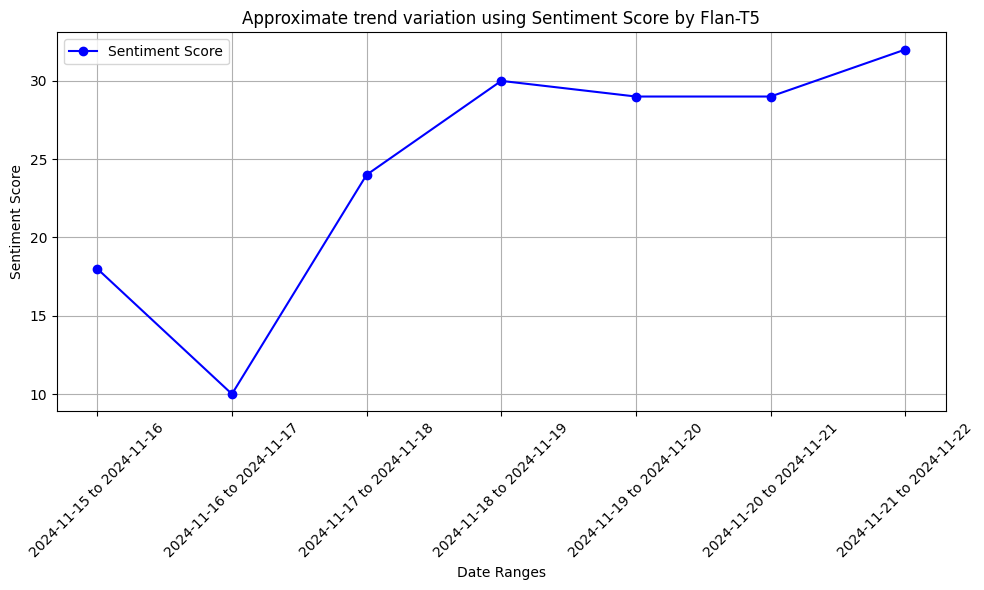

In [47]:
import matplotlib.pyplot as plt

# Define a mapping for sentiment values
sentiment_mapping = {"Positive": 1, "Negative": -1, "Neutral": 0}

# Define file names and corresponding date ranges
files_and_dates = [
    ("sentiment_data_0.json", "2024-11-15 to 2024-11-16"),
    ("sentiment_data_1.json", "2024-11-16 to 2024-11-17"),
    ("sentiment_data_2.json", "2024-11-17 to 2024-11-18"),
    ("sentiment_data_3.json", "2024-11-18 to 2024-11-19"),
    ("sentiment_data_4.json", "2024-11-19 to 2024-11-20"),
    ("sentiment_data_5.json", "2024-11-20 to 2024-11-21"),
    ("sentiment_data_6.json", "2024-11-21 to 2024-11-22"),
]

# Calculate sentiment scores
date_ranges = []
sentiment_scores = []

for file_name, date_range in files_and_dates:
    try:
        # Load the sentiment data
        with open(file_name, "r") as f:
            sentiments = json.load(f)
        # Calculate the total sentiment score
        total_score = sum(sentiment_mapping.get(sentiment, 0) for sentiment in sentiments)
        # Store the results
        date_ranges.append(date_range)
        sentiment_scores.append(total_score)
    except Exception as e:
        print(f"Error processing file {file_name}: {e}")

# Plot the sentiment score variation
plt.figure(figsize=(10, 6))
plt.plot(date_ranges, sentiment_scores, marker='o', color='b', label="Sentiment Score")
plt.xlabel("Date Ranges")
plt.ylabel("Sentiment Score")
plt.title("Approximate trend variation using Sentiment Score by Flan-T5")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Most Discussed topics from the articles

In [53]:
import openai
import os
import json

openai.api_key = ""  # open ai key 




def get_chatgpt_response(prompt, model="gpt-4o-mini", temperature=0.7, max_tokens=2048):
    completion = openai.ChatCompletion.create(
      model="gpt-4o-mini",
      messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": prompt}
      ],
        temperature=temperature,
        max_tokens=max_tokens,
    )

    return (completion.choices[0].message.content)



def top_k_openai(news_content, ticker, k):
    instruction = """ 
            You are an advanced text analysis model. Your task is to identify the most frequently discussed keywords or topics from a list of stock-related articles. Extract only the top {} most relevant keywords or topics based on their frequency and importance across all articles.

            List of Articles: {}

            Output: Provide a list of the top {} keywords or topics discussed in these articles, ranked by their relevance and frequency. Ensure the output is concise and formatted as a valid JSON list of strings. Avoid duplicate or overly generic terms.
            """


    prompt = instruction.format(k, news_content , k)

    # Get the response content
    top_k_discussed_topics = get_chatgpt_response(prompt).strip("```json")

    
    # # Save the results to JSON
    with open('top_k_openai.json', 'w') as f:
        json.dump(top_k_discussed_topics, f, indent=4)
    print("Data saved to 'top_k_openai.json'")

    return top_k_discussed_topics

In [54]:
if __name__ == "__main__":
    # use the api key for openai, not suggested to push the code with key
    
    file_path = "news_data.json"
    with open(file_path, 'r') as file:
        fetch_news_data = json.load(file)

    news_data = []
    for article in fetch_news_data["articles"]:
        extracted_news_data = extract_news_data(article["title"], article["description"], article["content"])
        # extract_news_data=extract_news_api(fetch_news_data)
        news_data.append(extracted_news_data)
        
    top_k_discussed_topics = top_k_openai(news_data,'apple stock', 5)
    print(top_k_discussed_topics)

Data saved to 'top_k_openai.json'

[
    "Warren Buffett",
    "Apple",
    "Black Friday",
    "Domino's Pizza",
    "Stock Market"
]

